1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
   
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import scipy as sp

In [2]:
N = 1000
mean = 0
std = 1
x = np.random.normal(loc=mean, scale=std, size=N)

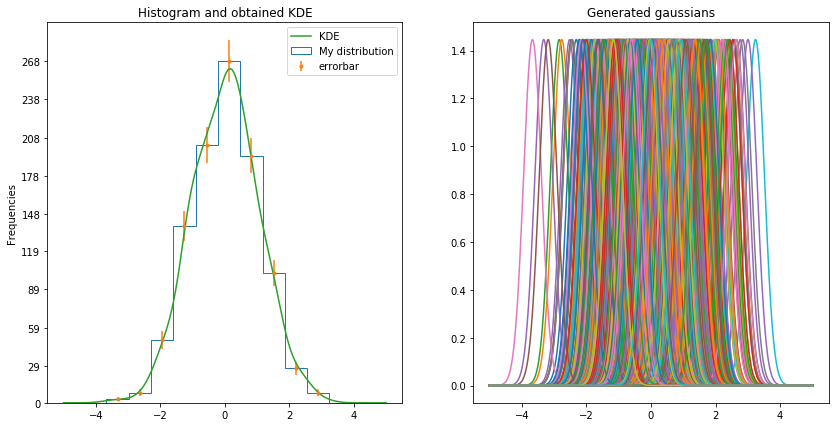

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
y, var, bins = ax1.hist(x,bins=10,histtype='step',label='My distribution')
cent = 0.5*(var[1:] + var[:-1])

ax1.errorbar(
    cent,
    y,
    yerr = y**0.5,
    marker = '.',
    drawstyle = 'steps-mid',
    ls='none',
    label = 'errorbar'
)
ax1.set_title('Histogram and obtained KDE')
ax1.set_ylabel('Frequencies')
ax1.set_yticks(ticks=np.linspace(0,y.max(),10,dtype=int))

s = 1.06 * x.std() * x.size**(-1/5)
gauss = []
for el in x:
    ls = np.linspace(-5, +5, num=N)
    rv = sp.stats.norm(el, s)
    gauss.append(rv.pdf(ls))
    ax2.plot(ls, gauss[-1])
ax2.set_title('Generated gaussians')

summed = np.sum(gauss, axis=0)/1000*(sp.integrate.trapz(y,x=var[1:]))
ax1.plot(ls, summed,label='KDE')
ax1.legend(markerscale=1)


2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

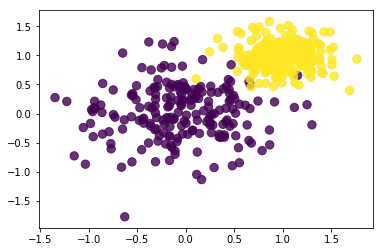

In [4]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


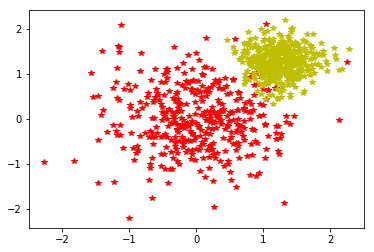

In [5]:
avg = [0, 0]
cov = [[0.5, 0], [0, 0.5]]
x, y  = np.random.multivariate_normal(avg, cov, 400).T
plt.plot(x,y,'r*')
avg = [1.25, 1.25]
cov = [[0.1, 0], [0, 0.1]]
x, y  = np.random.multivariate_normal(avg, cov, 400).T
plt.plot(x,y,'y*')

#all needed to do for N > 2 cats is replicate the code above
def scatter_n(n=2, mean = [-10,10], std = [-2, 2]):
    np.random.seed(10)
    for i in range(n):
        avg = np.random.uniform(low=mean[0],high=mean[1],size=2)
        cov = np.random.uniform(std[0],std[1],size=(2,2))
        cov = np.dot(cov, cov.T)
        x, y  = np.random.multivariate_normal(avg, cov, 100).T
        plt.plot(x,y,'*')

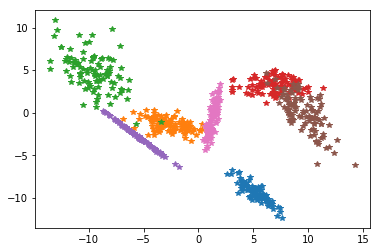

In [6]:
scatter_n(7)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

C:\Users\ELIA\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


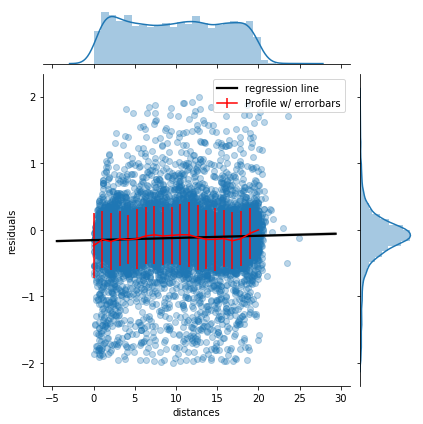

In [7]:
temp = np.load('residuals_261.npy').item()
df = pd.DataFrame(temp)
df = df[abs(df['residuals']) < 2]
lin = sp.stats.linregress(df['distances'], df['residuals'])
sb.jointplot( df['distances'],df['residuals'],kind='reg',
             scatter_kws = {'alpha':0.3},line_kws={'color':'black', 'label':'regression line'})

x = np.linspace(0,20,20)
df = df.sort_values('distances')

y = np.zeros(len(x))
count = 0
prev = x[0]
erry = np.zeros(len(x))

for i in x[1:]:
    temp = df[df['distances'] < i]
    temp = temp[temp['distances']>=prev]
    y[count] = temp['residuals'].mean()
    erry[count] = temp['residuals'].std()
    count += 1
    prev = i
    
plt.errorbar(x,y,yerr=erry, color='red', label='Profile w/ errorbars')
plt.legend()